# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.



## Loading needed libraries

In [1]:
# import needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose

# import machine learning packages
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

### Set environment variables

In [2]:
# set to display all output not only print() or last output
InteractiveShell.ast_node_interactivity = "all"

# set display all columns when showing dataframes
pd.options.display.max_columns = None

## Preparation

In this step I will load the data, perform exploratory data analysis and take care of the resampling of the time series data.

### Data loading

In [3]:
# load needed files, try/except to differentiate between running at home or on yandex jupyterhub
try:
    df_input = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df_input = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

### Exploratory data analysis

In [4]:
# display basic information about the dataframes we use
df_input.info()
df_input.describe()
df_input.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [5]:
# make sure index is sorted
print(df_input.index.is_monotonic)

True


I've summarized the discoveries below in the summary sub chapter.

### Resampling to hourly intervals

The data is sampled every 10 minutes and I've been asked to resample it to 1-hour intervals, so I will perform this.

In [6]:
# taking the sum of hourly intervals
df = df_input.resample('1H').sum()

### Summary of preparation

* Performed EDA, with the following discoveries:
    * Column names are lower case so no need to change
    * Data doesn't seem to be missing in any of the columns
    * In raw form, we have 26496 total observations, of which 0 rows are duplicates
    * datetime index is already sorted
    * We have 10 minute interval timepoints which I will resample to hourly sums
* Data was resampled from 10-minute intervals to 1-hour intervals.

## Analysis

In this step, I will look at the data more thoroughly, pick out features from the data and divide the dataset into train/test so we will be ready for the training in the next part.

### More thorough look

Let's start by looking at the whole set, and also see if we can recognize trends and seasonality in it

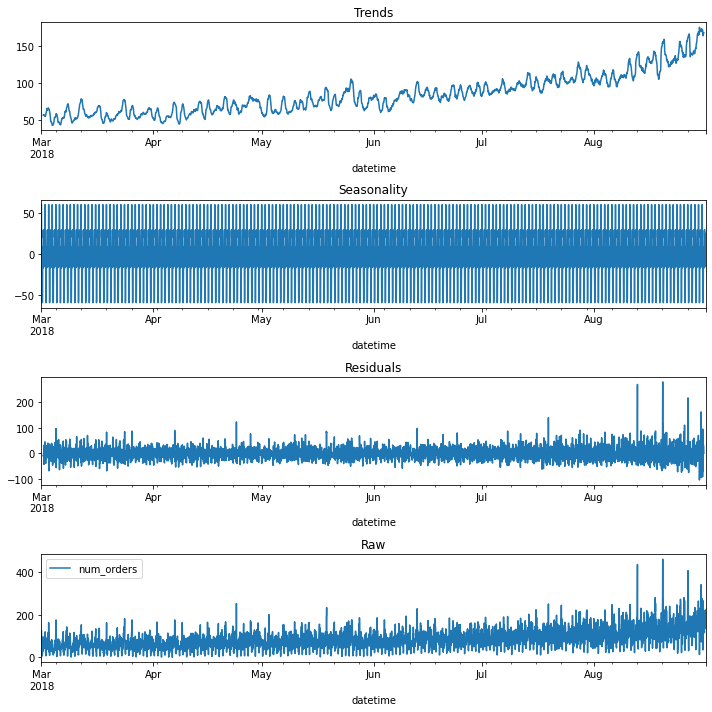

In [7]:
# decompose the time series to look for seasonality and trends
decomposed = seasonal_decompose(df)

# plot the data
plt.figure(figsize=(10, 10))
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trends')
plt.subplot(412)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(413)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.subplot(414)
df.plot(ax=plt.gca())
plt.title('Raw')
plt.tight_layout();

This is interesting - we can learn several things from this:
* We can see that in general things have been picking up for the taxi company and the trend is going up with time
* From the residuals we can note several outliers especially in August
* The model picked up a very short repeating seasonality, let's look at this more clearly

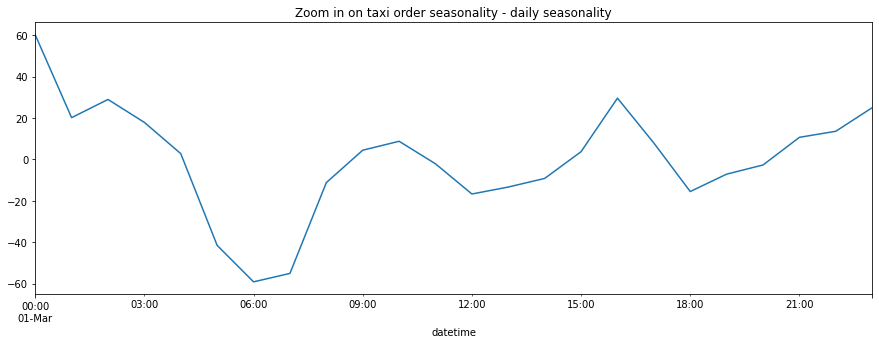

In [8]:
# plot short period to look at seasonality pattern
decomposed.seasonal['2018-03-01':'2018-03-01'].plot(figsize=(15,5))
plt.title('Zoom in on taxi order seasonality - daily seasonality');

After playing around with the date ranges I noticed that the seasonality appears to be repeated daily. We can see that the hour of the day has a really obvious effect on the value.

Based on these analyses, we can see that it would make sense for the model to know the hour of the day as a feature.
Also, based on the trend we picked up, we should add a feature that gives us a wide rolling average to account for the slow increase we noted. I'll try different windows to see which one more closely resembles the general trend we see. In addition, I'll try to add another rolling window feature which might help predict the shorter duration trends that can be seen in the trend decomposition.

### Adding features 

#### Rolling mean

We see two different resolutions of trends. One which is very general, and the other which creates some peaks and valleys over the general trend. After playing around comparing them to the trend above, I've decided on a daily and weekly rolling average to add as features.

In [9]:
# create rolling averages, use shift to not include current value in average
df['daily_rolling_mean'] = df['num_orders'].shift().rolling(24).mean()
df['weekly_rolling_mean'] = df['num_orders'].shift().rolling(24*7).mean()

#### Time-based features

As we've seen before, there is a strong hourly seasonality in the data. In addition, I'll assume the day of the week also has an influence on the amount of taxi cabs ordered.

In [10]:
# create features based on the time/date
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour

#### Lag-based features

For the finer-grained resolution, I'll add previous values in the form of lag of the data for the model to use. Based on the data above 1 to 6 timepoints seems to be enough to encode this.

In [11]:
# add lag-based time features
for lag in range(1, 7):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

#### Remove NaNs

Performing the rolling average and the shift for the lag introduced some NaNs which I will remove at this point.

In [12]:
# remove NaNs
df.dropna(inplace=True)

### Splitting the data

I'll separate between train/test sets and separate the features from the target.

In [13]:
# put aside 10% as requested for the test set
train, test = train_test_split(df, shuffle=False, test_size=0.1)

# separate between features and target
train_X = train.drop(columns='num_orders')
test_X = test.drop(columns='num_orders')
train_y = train['num_orders']
test_y = test['num_orders']

### Preparing a scaler for numerical columns, and time series cross validation object

Since the columns are numeric, I'll scale them down so that there is no difference between the features.

In [14]:
# decide which columns get transformed (all columns are numeric)
num_cols = train_X.columns.tolist()

# define possible transformers
scaler = StandardScaler()

# define column transformer for pipeline
preprocess = make_column_transformer(
    (scaler, num_cols),
    remainder='passthrough')

### Preparing time series cross validation object

Since regular cross validation samples the data randomly, this doesn't make sense for time series data. Hence, I will use TimeSeriesSplit instead to perform the splitting, with a gap between the train and validation sets each time so that the model doesn't learn the lag values.

In [15]:
# prepare 4 cross validation folds using TimeSeriesSplit so they are chosen correctly
# gap is used so that model doesn't learn values appearing in the lag_n features
tscv = TimeSeriesSplit(n_splits=4, gap=6)

### Summary of analysis:
* We performed seasonal decomposition to look for trends and seasonality
	* We discovered a general upwards trend over the whole time period
	* We noted outliers in the data of August
	* The model picked up a seasonality that is repeated daily
* Based on these analyses, we engineered features:
	* A daily and weekly rolling mean average of the orders
	* day of the week and hour of the day features
	* 24 lagged features
* Data was split 90:10 between the train and test sets
* Features were separated from the targets
* Prepared a StandardScaler() scaler for all the numerical columns
* Prepared a TimeSeriesSplit() splitter for the planned cross validation steps

## Training

I'll try 3 different models: LinearRegression(), RandomForestRegressor() and LGBMRegressor(). For the first I'll just perform a scoring using cross validation, for the other two I'll use a gridsearch cross validation to look for optimal hyperparameters. I'll StandardScaler() both the features and the target.

### Linear Regression

In [16]:
# define model
model_linear = LinearRegression()

# define pipeline
steps = [('preprocessing', preprocess), ('regression', model_linear)]
pipeline = Pipeline(steps)

# prepare the model with target scaling
full_linear_model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

# get scores for this model
results_linear = cross_val_score(full_linear_model, train_X, train_y, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1)

# print resulting scores of linear regression model
print('LinearRegression() model: mean of 4 cross validation RMSE scores: {:.3f}' .format(-results_linear.mean()))

LinearRegression() model: mean of 4 cross validation RMSE scores: 32.236


Seems like we are in the right direction, with a mean RMSE score smaller than 48.

### Random Forest Regression

In [17]:
# define model
model_forest = RandomForestRegressor()

# define pipeline
steps = [('preprocessing', preprocess), ('regression', model_forest)]
pipeline = Pipeline(steps)

# prepare the model with target scaling
full_forest_model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

# define parameters for the gridsearch
param_forest = {'regressor__regression__n_estimators' : range(10, 51, 10),
                'regressor__regression__max_depth' : range(3, 40, 5)}

# Perform the grid search cross validation
grid_forest = GridSearchCV(full_forest_model, param_grid=param_forest, cv=tscv, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)
results_forest = grid_forest.fit(train_X, train_y)

# print resulting best score and parameters - RandomForestRegressor
print("\nRandomForestRegressor() model:")
print('The best parameters across ALL searched params: \n   {}' .format(grid_forest.best_params_))
print('The best score across ALL searched params: {:.3f}' .format(-grid_forest.best_score_))
cv_results_forest = pd.DataFrame.from_dict(results_forest.cv_results_)

Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] END regressor__regression__max_depth=3, regressor__regression__n_estimators=10; total time=   0.1s
[CV] END regressor__regression__max_depth=3, regressor__regression__n_estimators=10; total time=   0.0s
[CV] END regressor__regression__max_depth=3, regressor__regression__n_estimators=10; total time=   0.0s
[CV] END regressor__regression__max_depth=3, regressor__regression__n_estimators=10; total time=   0.1s
[CV] END regressor__regression__max_depth=3, regressor__regression__n_estimators=20; total time=   0.0s
[CV] END regressor__regression__max_depth=3, regressor__regression__n_estimators=20; total time=   0.1s
[CV] END regressor__regression__max_depth=3, regressor__regression__n_estimators=20; total time=   0.1s
[CV] END regressor__regression__max_depth=3, regressor__regression__n_estimators=20; total time=   0.1s
[CV] END regressor__regression__max_depth=3, regressor__regression__n_estimators=30; total time=   0.1s
[C

In [18]:
# let's show the 10 best parameter combinations for random forest models
cv_results_forest.sort_values('rank_test_score').head(10)[['param_regressor__regression__max_depth', 
 'param_regressor__regression__n_estimators', 'mean_test_score', 'rank_test_score']]

,param_regressor__regression__max_depth,param_regressor__regression__n_estimators,mean_test_score,rank_test_score
17,18,30,-25.915894,1
29,28,50,-25.920195,2
27,28,30,-25.952242,3
14,13,50,-25.962133,4
39,38,50,-25.967248,5
33,33,40,-25.968148,6
19,18,50,-25.976886,7
18,18,40,-25.993264,8
13,13,40,-26.002850,9
24,23,50,-26.008842,10


We can see that the best results in our tests were with a max_depth of 18 and 30 estimators. This gives us an RMSE of \~25.9, which is an improvement over what we got from the linear regression.

### Light GBBM (gradient boost) Regression

In [19]:
# define model
model_lgbm = LGBMRegressor()

# define pipeline
steps = [('preprocessing', preprocess), ('regression', model_lgbm)]
pipeline = Pipeline(steps)

# prepare the model with target scaling
full_lightgb_model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

# define parameters for the gridsearch
param_lgbm = {'regressor__regression__boosting_type' : ['gbdt', 'dart', 'goss'],
              'regressor__regression__learning_rate' : [0.05, 0.075, 0.1],
              'regressor__regression__min_data_in_leaf' : [10, 100, 1000]}

# Perform the grid search cross validation
grid_lgbm = GridSearchCV(full_lightgb_model, param_grid=param_lgbm, cv=tscv, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)
results_lgbm = grid_lgbm.fit(train_X, train_y)

# print resulting best score and parameters - RandomForestRegressor
print("\nLGBMRegressor() model:")
print('The best parameters across ALL searched params: \n   {}' .format(grid_lgbm.best_params_))
print('The best score across ALL searched params: {:.3f}' .format(-grid_lgbm.best_score_))
cv_results_lgbm = pd.DataFrame.from_dict(results_lgbm.cv_results_)

Fitting 4 folds for each of 27 candidates, totalling 108 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END regressor__regression__boosting_type=gbdt, regressor__regression__learning_rate=0.05, regressor__regression__min_data_in_leaf=10; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END regressor__regression__boosting_type=gbdt, regressor__regression__learning_rate=0.05, regressor__regression__min_data_in_leaf=10; total time=   0.7s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END regressor__regression__boosting_type=gbdt, regressor__regression__learning_rate=0.05, regressor__regression__min_data_in_leaf=10; total time=   1.0s
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current val

In [20]:
# let's show the 10 best parameter combinations for lgbm 
cv_results_lgbm.sort_values('rank_test_score').head(10)[['param_regressor__regression__boosting_type', 
 'param_regressor__regression__learning_rate', 
'param_regressor__regression__min_data_in_leaf','mean_test_score', 'rank_test_score']]

,param_regressor__regression__boosting_type,param_regressor__regression__learning_rate,param_regressor__regression__min_data_in_leaf,mean_test_score,rank_test_score
0,gbdt,0.05,10,-26.385146,1
15,dart,0.1,10,-26.946538,2
18,goss,0.05,10,-26.948212,3
3,gbdt,0.075,10,-27.088247,4
7,gbdt,0.1,100,-27.158136,5
6,gbdt,0.1,10,-27.238407,6
4,gbdt,0.075,100,-27.307815,7
12,dart,0.075,10,-27.371155,8
1,gbdt,0.05,100,-27.646042,9
21,goss,0.075,10,-27.681740,10


Our best results were achieved using the gbdt boosting type algorithm, with the default learning rate of 0.05 and 10 minimum samples per leaf. This gave us a score of \~26, which is about the same as the Random Forest model but obviously better than the Linear Regression model. Also, this took less time to train than the random forest model.

## Testing

I will now use the parameters we found above to train the 3 models on the whole training set, then predict the test targets and finally compare the results by calculating the RMSE score between the predicted values and actual targets.

In [25]:
# define list to store scores
rmse_score = []
predictions = []

# define all the models with optimal parameters
models = [LinearRegression(),
          RandomForestRegressor(max_depth=18, n_estimators=30),
          LGBMRegressor(boosting_type='gbdt', learning_rate=0.05, min_data_in_leaf=10)]

# define all model names
model_names = ['LinearRegression()', 'RandomForestRegressor()', 'LGBMRegressor()']

In [26]:
# loop through models and run them all
for model, model_name in zip(models, model_names):

    # define pipeline
    steps = [('preprocessing', preprocess), ('regression', model)]
    pipeline = Pipeline(steps)
    
    # prepare the model with target scaling
    model = TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())
    
    # train model
    model.fit(train_X, train_y)
    
    # predict results for test set
    predicted_y = model.predict(test_X)
    predictions.append([model_name, predicted_y])
    
    # calculate RMSE for this model
    rmse_score.append([model_name, mean_squared_error(test_y, predicted_y, squared=False)])

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('standardscaler',
                                                                                       StandardScaler(),
                                                                                       ['daily_rolling_mean',
                                                                                        'weekly_rolling_mean',
                                                                                        'dayofweek',
                                                                                        'hour',
                                                                                        'lag_1',
                                                                                        'lag_2',
          

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('standardscaler',
                                                                                       StandardScaler(),
                                                                                       ['daily_rolling_mean',
                                                                                        'weekly_rolling_mean',
                                                                                        'dayofweek',
                                                                                        'hour',
                                                                                        'lag_1',
                                                                                        'lag_2',
          

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('standardscaler',
                                                                                       StandardScaler(),
                                                                                       ['daily_rolling_mean',
                                                                                        'weekly_rolling_mean',
                                                                                        'dayofweek',
                                                                                        'hour',
                                                                                        'lag_1',
                                                                                        'lag_2',
          

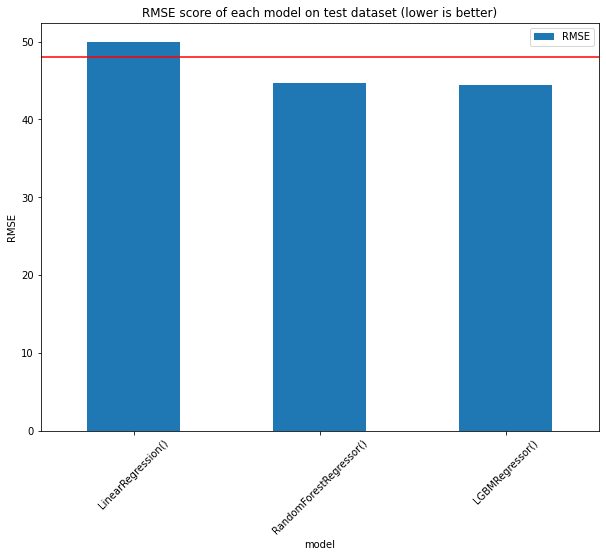

In [27]:
# plot bar chart of RMSE
pd.DataFrame(rmse_score, columns=['model', 'RMSE']).plot(kind='bar', x='model', figsize=(10,7.5), title='RMSE score of each model on test dataset (lower is better)')
plt.ylabel('RMSE')
plt.axhline(48, color='red')
plt.xticks(rotation=45);

### Conclusion

We trained the models and tested them on the test set. We received worse results than during the cross validation, but still managed to beat the RMSE score of 48 using the random forest and light gradient boosting models, with the RandomForest and LGBM regressor giving us close results around ~44. That being said, training the LGBM regressor (and testing various options during the gridsearch cross validation) took a lot less time than the random forest regressor.

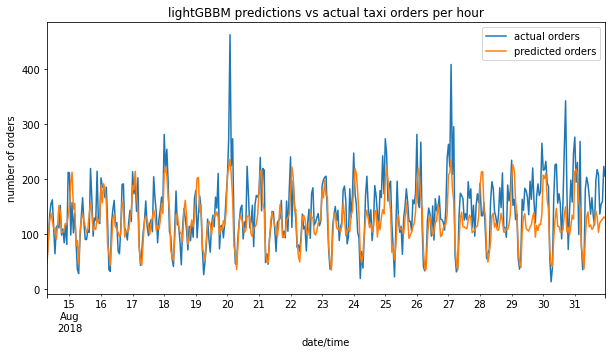

In [30]:
test_y.plot(figsize=(10,5), title='lightGBBM predictions vs actual taxi orders per hour')
pd.DataFrame(predictions[2][1], index=test_y.index).plot(ax=plt.gca())
plt.xlabel('date/time')
plt.ylabel('number of orders')
plt.legend(['actual orders', 'predicted orders']);

We can see that in general the predictions are not far off from the actual results, but as expected the outliers we witnessed earlier in the analysis part are spots where there is a larger difference between the predictions and the actual results.